# Experiment set-up and information on the calcium traces
Set up of the problem and out experiment

List of plots in the figure so far: 
- a. schematic of microscope and environment's setup
- b. Schematic of how two environments are different + summary of experiments structure (training + recordings)
- c. Slice of HP to shoe the aread targetd + calcium traces example
- d. Plot showing the behaviour of the mouse for 20 minutes of recordings
- e. Example of cells remapping (events over traces) over two sessions
- f. Show the tuning curves ordered for one session and the another

In [1]:
import os
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.sys.path.append(parent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go

from tools.data_formatting import get_smoothed_moving_all_data, get_common_indexes_2recordings, smooth_tuning_curves_circularly
from tools.data_manager import get_all_experiments_runs
from tools.alignment import procrustes, canoncorr
from global_vars import order_experiments

## Fig.1.a

In [46]:
### Load all dessions ###

animal = 'm120'
fov = 'fov1'
sessions = get_all_experiments_runs(animal, fov)
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

all_cells = []
all_tuning_curves = []
for (experiment, run) in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(animal, fov, experiment, run)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)
all_tuning_curves = np.array(all_tuning_curves)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (7, 360) + inhomogeneous part.

In [44]:
### Plot tuning curves before alignment ###

# Concatenate all the tuning curves
concatenated_tuning_curves = np.concatenate(all_tuning_curves, axis=0)
pca = PCA(n_components=20)
pca_tuning_curves = pca.fit_transform(concatenated_tuning_curves)
# split the tunign curves (every 360 points)
pca_tuning_curves = np.split(pca_tuning_curves, len(sessions), axis=0)

# # Reference session
# ref_experiment, ref_run = sessions[0]
# ref_tuning_curves = all_tuning_curves[0]
# pca = PCA(n_components=20)
# pca_ref_tuning_curves = pca.fit_transform(ref_tuning_curves)
# ref_smoothed_tuning_curves = smooth_tuning_curves_circularly(pca_ref_tuning_curves, kernel_size=20)

# # Transform all tuning curves in a PCA space
# all_pca_tuning_curves = [pca.fit_transform(tuning_curves) for tuning_curves in all_tuning_curves[1:]]
# all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_pca_tuning_curves]

colors = ['#cd001a', '#ef6a00', '#f2cd00', '#79c300', '#1961ae', '#61007d']
colors2 = ["#eb5e28","#f9a03f","#f3c053","#a1c349","#87a330","#6a8532", "#61007d"]
fig = go.Figure()
for i in range(len(pca_tuning_curves)):
    fig.add_trace(go.Scatter3d(x=pca_tuning_curves[i][:, 0], y=pca_tuning_curves[i][:, 1], z=pca_tuning_curves[i][:, 2], 
                               mode='markers', marker=dict(size=2, color=colors2[i], opacity=0.2), showlegend=False))
    fig.add_trace(go.Scatter3d(x=pca_tuning_curves[i][:, 0], y=pca_tuning_curves[i][:, 1], z=pca_tuning_curves[i][:, 2], 
                               mode='lines', line=dict(color=colors2[i], width=5), name=f'{sessions[i+1][0]}-{sessions[i+1][1]}'))
# # Add the reference trace
# fig.add_trace(go.Scatter3d(x=ref_smoothed_tuning_curves[:, 0], y=ref_smoothed_tuning_curves[:, 1], z=ref_smoothed_tuning_curves[:, 2],
#                            mode='lines', line=dict(color='black', width=5), name=f'reference: {ref_experiment}-{ref_run}'))
# Add title
fig.update_layout(title='Tuning curves before alignment')
fig.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 156 and the array at index 2 has size 186

In [12]:
# Take as a reference the first session 
ref_experiment, ref_run = sessions[0]
ref_tuning_curves = all_tuning_curves[0]
ref_cells = all_cells[0]
pca = PCA(n_components=20)
pca_ref_tuning_curves = pca.fit_transform(ref_tuning_curves)

# Variables to save the embeddings
all_d = []
all_tform = []
all_tuning_curves_transformed = []
for i, (experiment, run) in enumerate(sessions[1:]):
        tuning_curves = all_tuning_curves[i]
        pca_tuning_curves = pca.fit_transform(tuning_curves)
        d, pca_tuning_curves_transformed, tform = procrustes(pca_ref_tuning_curves, pca_tuning_curves)
        all_d.append(d)
        all_tform.append(tform)
        all_tuning_curves_transformed.append(pca_tuning_curves_transformed)
# Save their smoothed version
all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_tuning_curves_transformed]

colors = ['#01befe', '#ffdd00', '#ff7d00', '#ff006d', '#adff02', '#8f00ff']
fig = go.Figure()
for i in range(len(all_tuning_curves_transformed)):
    fig.add_trace(go.Scatter3d(x=all_tuning_curves_transformed[i][:, 0], y=all_tuning_curves_transformed[i][:, 1], z=all_tuning_curves_transformed[i][:, 2], 
                               mode='markers', marker=dict(size=2, color=colors[i], opacity=0.2)))
    fig.add_trace(go.Scatter3d(x=all_smoothed_tuning_curves[i][:, 0], y=all_smoothed_tuning_curves[i][:, 1], z=all_smoothed_tuning_curves[i][:, 2], 
                               mode='lines', line=dict(color=colors[i], width=3)))

fig.show()

In [ ]:
# Take as a reference the first session 
ref_experiment, ref_run = sessions[0]
ref_tuning_curves = all_tuning_curves[0]
ref_cells = all_cells[0]
pca = PCA(n_components=20)
pca_ref_tuning_curves = pca.fit_transform(ref_tuning_curves)

# Variables to save the embeddings
all_d = []
all_tform = []
all_tuning_curves_transformed = []
for i, (experiment, run) in enumerate(sessions[1:]):
        tuning_curves = all_tuning_curves[i]
        pca_tuning_curves = pca.fit_transform(tuning_curves)
        A, B, r, _, cca_tuning_curves = canoncorr(pca_ref_tuning_curves, pca_tuning_curves, fullReturn=True)
        all_tuning_curves_transformed.append(cca_tuning_curves @ np.linalg.inv(A))
# Save their smoothed version
all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_tuning_curves_transformed]
ref_smoothed_tuning_curves = smooth_tuning_curves_circularly(pca_ref_tuning_curves, kernel_size=20)

colors = ['#cd001a', '#ef6a00', '#f2cd00', '#79c300', '#1961ae', '#61007d']
fig = go.Figure()
for i in range(len(all_tuning_curves_transformed)):
    fig.add_trace(go.Scatter3d(x=all_tuning_curves_transformed[i][:, 0], y=all_tuning_curves_transformed[i][:, 1], z=all_tuning_curves_transformed[i][:, 2], 
                               mode='markers', marker=dict(size=2, color=colors[i], opacity=0.2), showlegend=False))
    fig.add_trace(go.Scatter3d(x=all_smoothed_tuning_curves[i][:, 0], y=all_smoothed_tuning_curves[i][:, 1], z=all_smoothed_tuning_curves[i][:, 2], 
                               mode='lines', line=dict(color=colors[i], width=5), name=f'{sessions[i+1][0]}-{sessions[i+1][1]}'))
# Add the reference trace
fig.add_trace(go.Scatter3d(x=ref_smoothed_tuning_curves[:, 0], y=ref_smoothed_tuning_curves[:, 1], z=ref_smoothed_tuning_curves[:, 2],
                           mode='lines', line=dict(color='black', width=5), name=f'{ref_experiment}-{ref_run}'))
# Add title
fig.update_layout(title='Tuning curves after alignment')
fig.show()

In [28]:
# Show without alignment what they would look like
all_pca_tuning_curves = [pca.fit_transform(tuning_curves) for tuning_curves in all_tuning_curves]
all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_pca_tuning_curves]

colors = ['#cd001a', '#ef6a00', '#f2cd00', '#79c300', '#1961ae', '#61007d']
fig = go.Figure()
for i in range(len(all_tuning_curves_transformed)):
    fig.add_trace(go.Scatter3d(x=all_pca_tuning_curves[i][:, 0], y=all_pca_tuning_curves[i][:, 1], z=all_pca_tuning_curves[i][:, 2], 
                               mode='markers', marker=dict(size=2, color=colors[i], opacity=0.2), showlegend=False))
    fig.add_trace(go.Scatter3d(x=all_smoothed_tuning_curves[i][:, 0], y=all_smoothed_tuning_curves[i][:, 1], z=all_smoothed_tuning_curves[i][:, 2], 
                               mode='lines', line=dict(color=colors[i], width=5), name=f'{sessions[i+1][0]}-{sessions[i+1][1]}'))
# Add the reference trace
fig.add_trace(go.Scatter3d(x=ref_smoothed_tuning_curves[:, 0], y=ref_smoothed_tuning_curves[:, 1], z=ref_smoothed_tuning_curves[:, 2],
                           mode='lines', line=dict(color='black', width=5), name=f'{ref_experiment}-{ref_run}'))
# Add title
fig.update_layout(title='Tuning curves before alignment')
fig.show()


## Fig.1.f

In [13]:
# Load data
animal = 'm120'
fov = 'fov1'
experiment1 = 'fam1novfam1'
run1 = 'fam1'
experiment2 = 'fam1novfam1'
run2 = 'fam1r2'
n_points = 360

firing_rates_run1, time_run1, phi_run1, cells_run1, tuning_curves1, phi_bins_run1 = get_smoothed_moving_all_data(animal, fov, experiment1, run1, n_points=n_points)
firing_rates_run2, time_run2, phi_run2, cells_run2, tuning_curves2, phi_bins_run2 = get_smoothed_moving_all_data(animal, fov, experiment2, run2, n_points=n_points)

common_cells_run1, common_cells_run2, ordered_cells_run1, ordered_cells_run2 = get_common_indexes_2recordings(cells_run1, cells_run2)
firing_rates_run1 = firing_rates_run1[:, common_cells_run1]
firing_rates_run2 = firing_rates_run2[:, common_cells_run2][:, ordered_cells_run2]
tuning_curves1 = tuning_curves1[:, common_cells_run1][:, ordered_cells_run1]
tuning_curves2 = tuning_curves2[:, common_cells_run2][:, ordered_cells_run2]
cells_run1 = cells_run1[common_cells_run1][ordered_cells_run1]
cells_run2 = cells_run2[common_cells_run2][ordered_cells_run2]

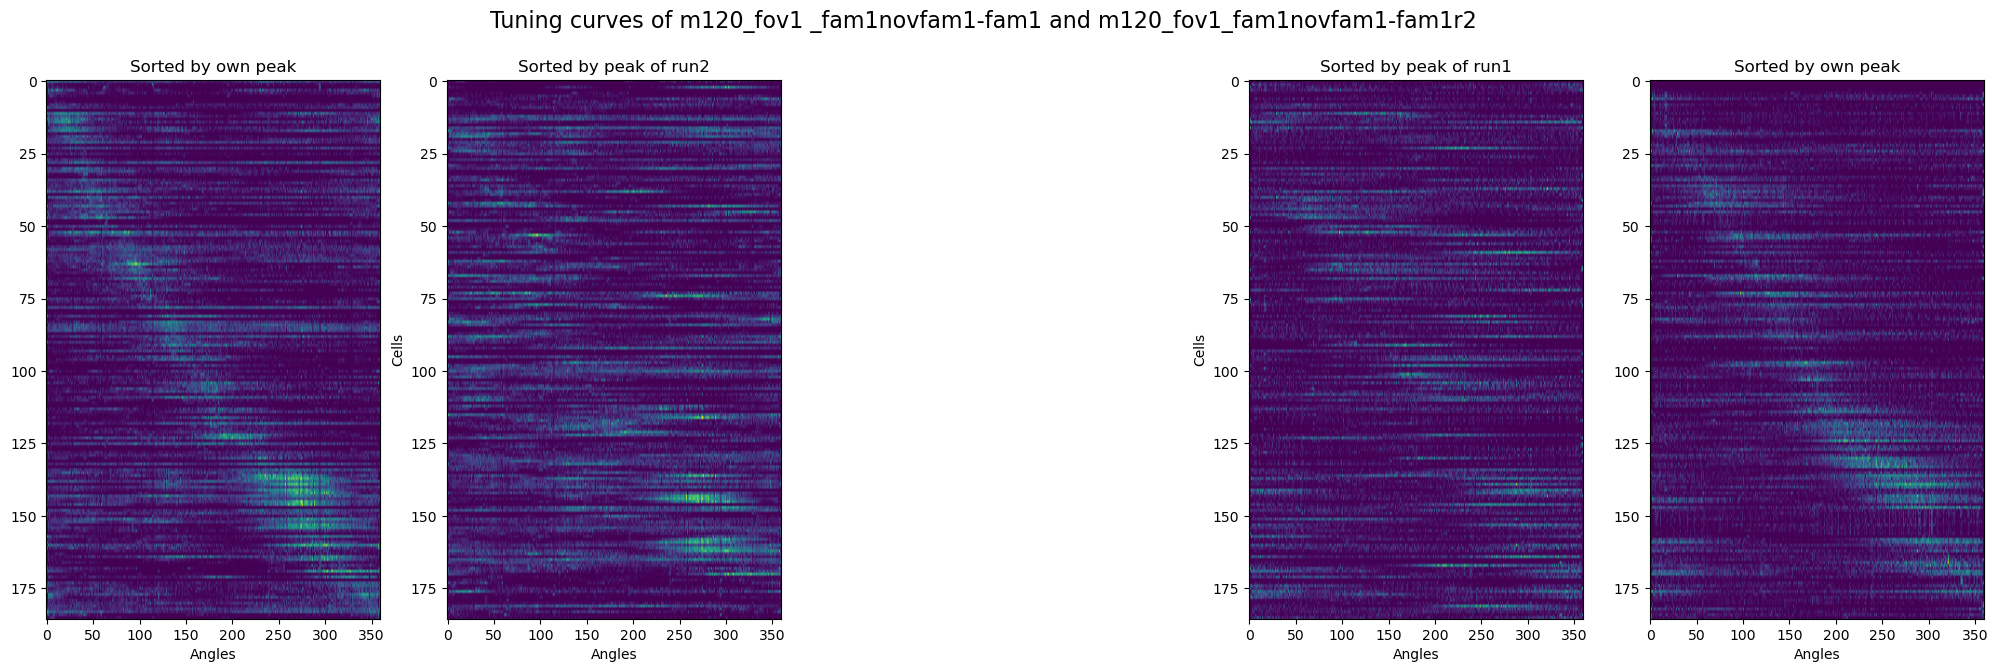

In [14]:
# Plot them
fig = plt.figure(figsize=(25, 7))
fig.suptitle(f'Tuning curves of {animal}_{fov} _{experiment1}-{run1} and {animal}_{fov}_{experiment2}-{run2}', fontsize=16)
grid = plt.GridSpec(ncols=5, nrows=1)

## Sorted by own peak
# Run1
ax = fig.add_subplot(grid[0, 0])
smoothed_tuning_curves1 = np.zeros((tuning_curves1.shape))
for i in range(tuning_curves1.shape[1]):
    smoothed_tuning_curves1[:,i] = np.convolve(tuning_curves1[:,i], np.ones((16,))/16, mode='same')
sorted_id_run1 = np.argsort(np.argmax(smoothed_tuning_curves1, axis=0))
ax.imshow(tuning_curves1[:,sorted_id_run1].T, aspect='auto')
ax.set_xlabel('Angles')
ax.set_title('Sorted by own peak')
# Run2
ax = fig.add_subplot(grid[0, 4])
smoothed_ring2 = np.zeros((tuning_curves2.shape))
for i in range(tuning_curves2.shape[1]):
    smoothed_ring2[:,i] = np.convolve(tuning_curves2[:,i], np.ones((16,))/16, mode='same')
sorted_id_run2 = np.argsort(np.argmax(smoothed_ring2, axis=0))
ax.imshow(tuning_curves2[:,sorted_id_run2].T, aspect='auto')
ax.set_xlabel('Angles')
ax.set_title('Sorted by own peak')

## Sorted by peak of the other run
# Run1
ax = fig.add_subplot(grid[0, 1])
ax.imshow(tuning_curves1[:,sorted_id_run2].T, aspect='auto')
ax.set_xlabel('Angles')
ax.set_ylabel('Cells')
ax.set_title('Sorted by peak of run2')
# Run2
ax = fig.add_subplot(grid[0, 3])
ax.imshow(tuning_curves2[:,sorted_id_run1].T, aspect='auto')
ax.set_xlabel('Angles')
ax.set_ylabel('Cells')
ax.set_title('Sorted by peak of run1')


plt.show()

# TODO can add a distribution of the shifts underneeath